In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib notebook

## User settings

In [2]:
N = 200 # number of nodes
L = 1 # domain length
dt = 0.0001 # time step
t0 = 0 # initial time instant

theta = 0 # for the selection of method in time

peclet = 5 # Peclet number
kappa = 0.1 # thermal diffusivity

tright = 1 # temperature at the end of the beam
tleft = 0 # temperature at the root of the beam

refresh_time = 5 # basically the inverse of the framerate, in MILLISECONDS

## Actual code

Mesh and stability check:

In [3]:
x = np.linspace(0, L, num=N)
dx = L/(N-1) # grid resolution
U = peclet/L*kappa # convection velocity
print() # new line
print('Local Peclet number: ', dx*U/kappa) # local Peclet number (stab. of stat. conv-diff)
print('Fourier number: ', kappa*dt/(dx**2)) # Fourier number (stab. of diffusion in time)
print('CFL number: ', dt*U/dx) # CFL umber (stab. of convection in time)
print() # new line


Local Peclet number:  0.025125628140703515
Fourier number:  0.39601000000000003
CFL number:  0.00995



### Calculation of matrix `B`:

Calculate matrix __B__ discretising the advection diffusion operator, so that:

$$ (\textbf{I} - \Delta t \, \theta \, \textbf{B})\, \vec{T}^{n+1} = (\textbf{I} + \Delta t \, (1-\theta) \, \textbf{B}) \vec{T}^{n} $$

notice that __B__ does not include boundary conditions yet.

Hint: this step is very similar to the the stationary problem. Actually, re-use the same __A__ from steady problems to find the steady solution; then, you need to make a little modification before using __B__ it for the unsteady solution.

In [4]:
# calcolate coefficients depending on choice of scheme
#         convection     diffusion
BE =    - U / (2*dx)   + kappa/(dx**2)
BW =      U / (2*dx)   + kappa/(dx**2)
BP =          0        - 2*kappa/(dx**2)

# calculation of B
B = BW*np.diag(np.ones(N-1),-1) + BE*np.diag(np.ones(N-1),1) + BP*np.diag(np.ones(N))

### Function to apply boundary conditions
This takes a matrix __M__ and a vector $\vec{v}$ and modifies the first and last rows in order to account for boundary conditions.

In [5]:
def apply_bc(M,v):
    # this takes a matrix and a vector and modifies first and last row
    # in order to account for boundary conditions

    # delete first and last rows
    M[0,:] = 0;     M[-1,:] = 0

    # apply Dirichlet condition
    M[0,0] = 1;     M[-1,-1] = 1
    v[0] = tleft;   v[-1] = tright

    return M,v

### Compute steady solution

In [6]:
b = np.zeros(N)
B,b = apply_bc(B,b)
steady_sol = np.linalg.solve(B, b)
steady_exact = b[0] + (np.exp(peclet*x/L)-1)/(np.exp(peclet)-1) * (b[-1] - b[0])

### Initial condition
Allocate the initial condition and plot it.

<IPython.core.display.Javascript object>


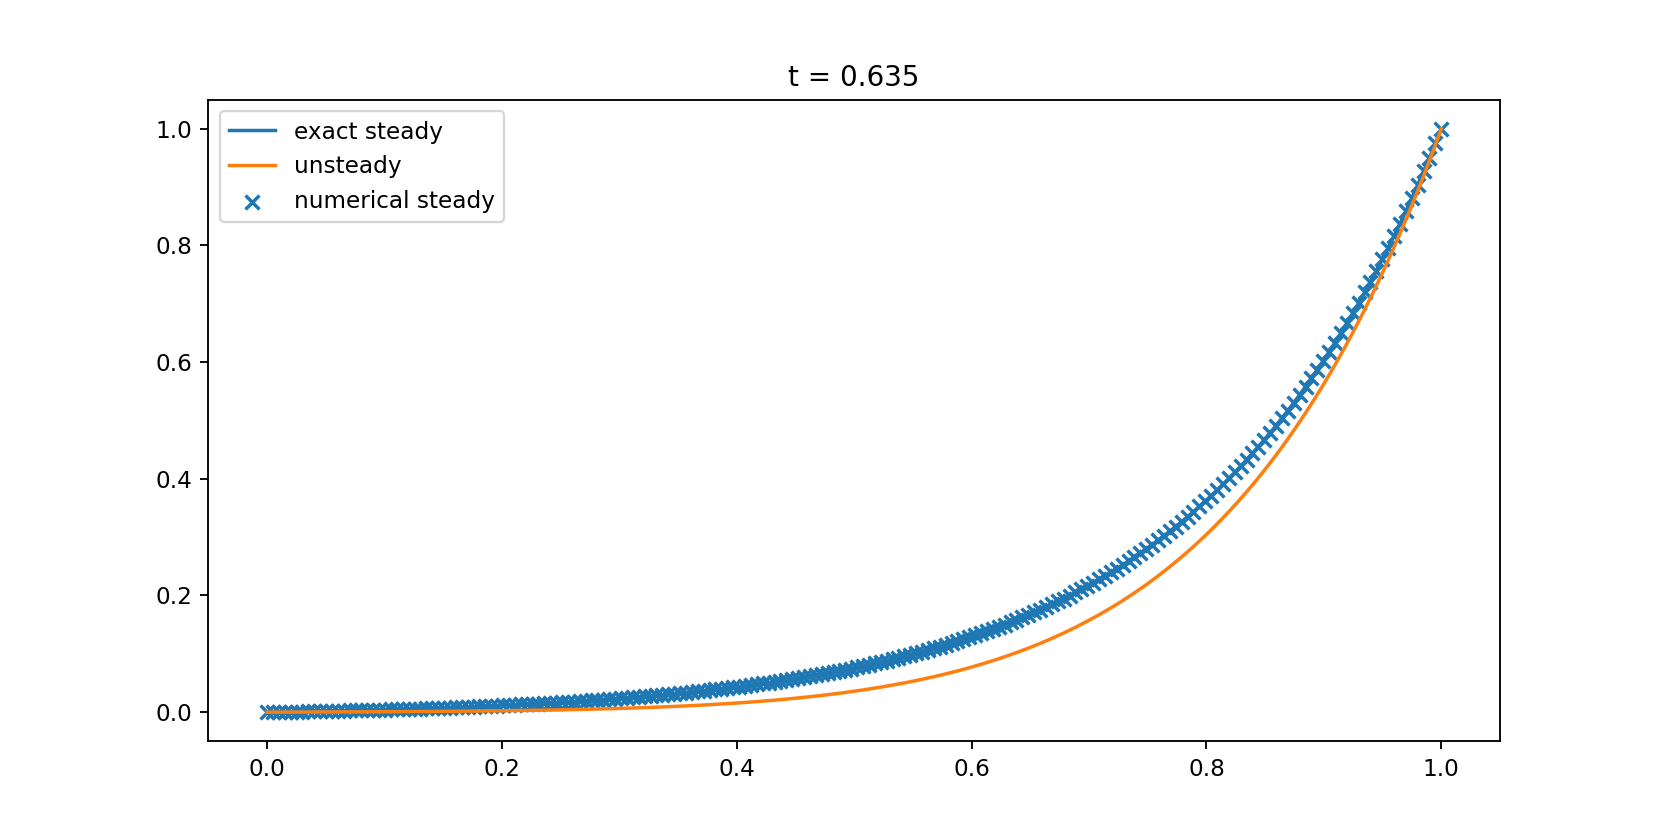

Text(0.5, 1.0, 't = 0')

In [7]:
t_curr = np.zeros_like(x) # temperature field at current instant
t_curr[-1] = tright
t_new = np.zeros_like(x) # temperature field at next time step

# plot initial condition! this plot will be updated by animation
fig, ax = plt.subplots(figsize=(10,5)) # create a figure and a system of axes inside it
ax.scatter(x, steady_sol, marker='x') # plot the steady numerical solution point by point
ax.plot(x, steady_exact) # plot the steady exact solution
solplot = ax.plot(x, t_curr) # plot the temperature field
ax.legend(['exact steady', 'unsteady', 'numerical steady']) # add a legend
ax.set_title('t = '+str(round(t0, 3))) # add a title containing time instant at which
                                       # temperature field is plotted


Matrices for the time step:

In [8]:
# Matrix of coefficients (multiplies T_{n+1})
A = np.identity(N) - dt * theta * B

# Matrix that returns know term
E = np.identity(N) + dt * (1-theta) * B

# A * t_new = E * t_curr

Time step function:

In [9]:
def time_step(ii):

    global t_curr, t_new, b, A, E, t0

    # get known term and apply bc
    b[:] = E.dot(t_curr)
    A,b = apply_bc(A,b)

    # solve system
    t_new[:] = np.linalg.solve(A,b)

    # update
    t0 += dt
    buffer_pointer = t_curr
    t_curr = t_new
    t_new = buffer_pointer

    # plot
    solplot[0].set_ydata(t_curr)
    ax.set_title('t = '+str(round(t0, 3)))

    return solplot

Animation (replaces time loop):

In [10]:
animation = FuncAnimation(fig, func=time_step, interval=refresh_time)
plt.show()